In [262]:
import gudhi.representations
import numpy as np
from sklearn.cluster import KMeans
import gudhi as gd
import matplotlib.pyplot as plt

In [263]:
import numpy as np
import matplotlib.image as mpimg       # reading images to numpy arrays

%matplotlib inline
import matplotlib.pyplot as plt        # to plot any graph

from skimage import measure            # to find shape contour
import scipy.ndimage as ndi            # to determine shape centrality

from scipy import interpolate
from sklearn.utils import shuffle

In [264]:
subject_set = ['circle', 'square','star','triangle']
Four_data = np.zeros((400,360))
Four_class = np.zeros(400)

In [265]:
from scipy.interpolate import CubicSpline
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from scipy.interpolate import PchipInterpolator

def convert_to_1d_polar(file, K=360):
    
    img = plt.imread(file).astype(float)

    # grayscale
    if img.ndim == 3:
        img = rgb2gray(img)
    if img.max() > 1:
        img = img / 255.0

    thr  = threshold_otsu(img)
    mask = (img < thr)  
    lab  = label(mask)
    r    = max(regionprops(lab), key=lambda rr: rr.area)
    cy, cx = r.centroid

    contours = measure.find_contours(mask.astype(float), 0.5)
    if not contours:
        raise ValueError("No contour found.")
    cont = max(contours, key=len)   # (N, 2) = (row, col)

    dy = cont[:, 0] - cy
    dx = cont[:, 1] - cx
    theta = np.mod(np.arctan2(dy, dx), 2*np.pi)   # [0, 2π)
    rad   = np.hypot(dx, dy)

    order = np.argsort(theta)
    th = theta[order]
    rd = rad[order]

    if len(th) > 1:
        keep = [0]
        for i in range(1, len(th)):
            if th[i] - th[keep[-1]] > 1e-8:
                keep.append(i)
        th, rd = th[keep], rd[keep]

    th_min = th[0]
    th_ext = np.r_[th - 2*np.pi, th, th + 2*np.pi]
    rd_ext = np.r_[rd,           rd, rd]
    interp = PchipInterpolator(th_ext, rd_ext, extrapolate=False)

    th_new = np.linspace(0, 2*np.pi, K, endpoint=False)
    th_q   = ((th_new - th_min) % (2*np.pi)) + th_min  # 래핑
    r_theta = interp(th_q)

    r_theta = np.clip(r_theta, 0.0, None)
    m = np.max(r_theta)
    if m > 0:
        r_theta = r_theta / m

    return r_theta

In [266]:
for j in range(4):
    subject = subject_set[j]
    times = 100*j

    for i in range(times, times+100):
        y = convert_to_1d_polar('shapes/%s/%d.png' %(subject,i-times))


        Four_data[i] = y
        Four_class[i] = j

In [267]:
Four_data = np.hstack((Four_data,Four_class.reshape(400,1)))

# Data

In [268]:
data = Four_data
label = data[:,-1]
data = data[:,:-1]
['circle', 'square','star','triangle']

['circle', 'square', 'star', 'triangle']

In [269]:
circle = data[np.where(data[:,-1]==0)]
square = data[np.where(data[:,-1]==1)]
star = data[np.where(data[:,-1]==2)]
triangle = data[np.where(data[:,-1]==3)]

In [270]:
frequencies = [1,2,3,4,5]
max_frequency = len(frequencies)
n_clusters = 5
direction = [1.0,1.0,1.0,1.0,0.2] 
endpoint = [0,0,0,0,0]
resolution = 50

In [271]:
km = KMeans(n_clusters=n_clusters, init='random', n_init=100, max_iter=300, tol=1e-4, random_state=0)

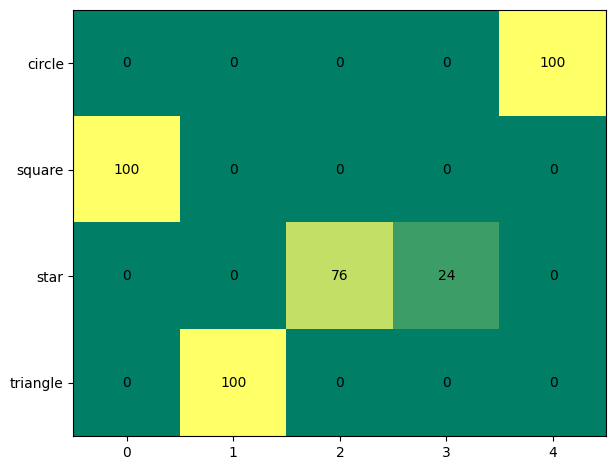

In [272]:
result = np.zeros((len(data),resolution*resolution))

birth_time = np.zeros((len(data),max_frequency))
death_time = np.zeros((len(data),max_frequency))
persistence_diagram = []


for i in range(len(data)):
    birth_temp = ( -np.array(endpoint))/(np.sqrt(max_frequency)*np.array(direction))
    birth_time[i] = birth_temp
    death_temp = (2*np.sqrt(3)* abs(np.fft.fft(np.array(data[i]))[1:max_frequency+1])/data.shape[1] - endpoint)/(np.sqrt(max_frequency)*np.array(direction))
    death_time[i] = death_temp
    persistence_diagram.append(np.vstack((birth_time[i],death_time[i])).T)
    
   
PI = gd.representations.vector_methods.PersistenceImage(bandwidth=0.05, weight=lambda x: x[1], 
                            resolution=[resolution, resolution], im_range=[0, np.max(np.array(persistence_diagram)), 0, np.max(np.array(persistence_diagram))])


for i in range(len(data)):
    a = persistence_diagram[i] 
    result[i] = (PI(a)-np.min(PI(a)))/(np.max(PI(a)) - np.min(PI(a)))
    
y_km = km.fit_predict(result)

    
cm2 = np.zeros((4, n_clusters))
for i in range(4):
    for j in range(n_clusters):
        cm2[i,j] = len(np.where((label==i) & (y_km == j))[0])

plt.xticks(range(n_clusters))
plt.yticks(range(4),labels = ['circle','square','star','triangle'])
plt.imshow(cm2)
for i in range(cm2.shape[0]):
    for j in range(cm2.shape[1]):
        plt.text(j,i,int(cm2[i,j]),ha='center',va='center')
        
plt.summer()      
plt.tight_layout()

In [273]:
star1 = np.where((label==2)&(y_km==2))
star2 = np.where((label==2)&(y_km==3))

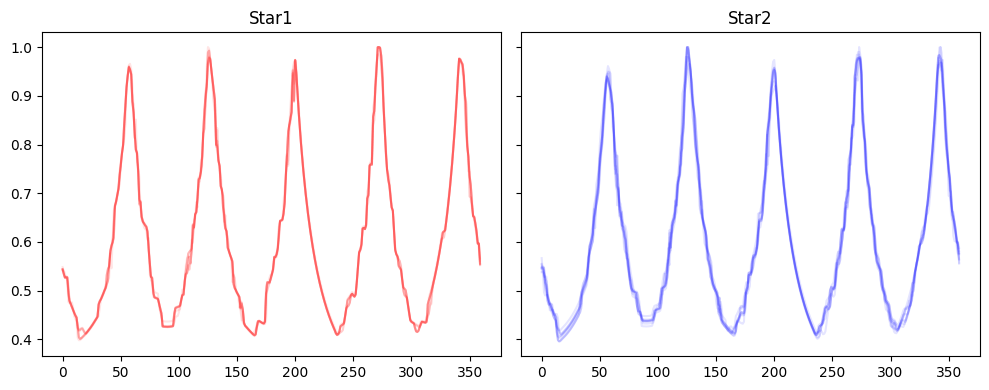

In [274]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axes[0].plot(data[star1].T[:, :9], color='red', alpha=0.1)
axes[0].set_title("Star1")

axes[1].plot(data[star2].T[:, :9], color='blue', alpha=0.1)
axes[1].set_title("Star2")

plt.tight_layout()
plt.show()


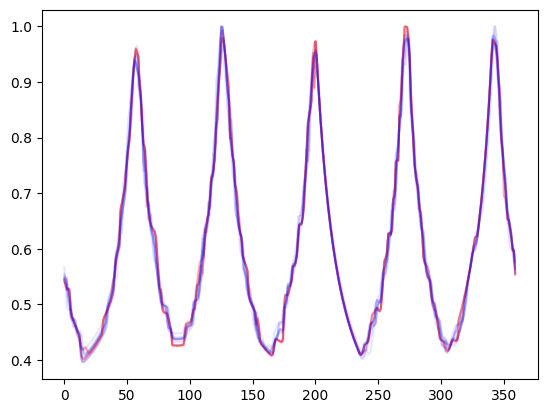

In [275]:
plt.plot(data[star1].T[:,:9], color='red', alpha=0.1) 
plt.plot(data[star2].T[:,:9], color='blue', alpha=0.1) 
plt.show()

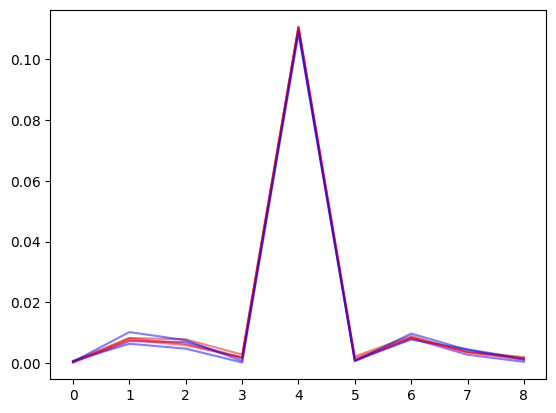

In [276]:
for i in range(3):
    plt.plot(np.abs(np.fft.fft(data[star1].T[:,i]))[1:10]/360, color='red', alpha=0.5)
    plt.plot(np.abs(np.fft.fft(data[star2].T[:,i]))[1:10]/360, color='blue', alpha=0.5)
plt.show()

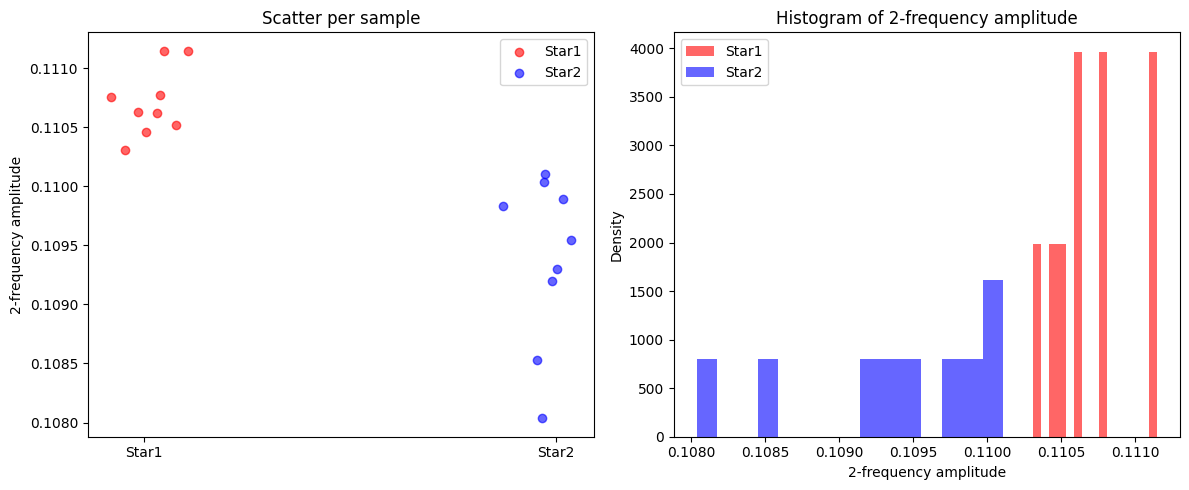

In [277]:
import numpy as np
import matplotlib.pyplot as plt

def second_freq_amplitude(x):
    return np.abs(np.fft.fft(x))[2] / len(x)

amp_X = []
amp_Y = []

for i in range(9):
    amp_X.append(np.abs(np.fft.fft(data[star1].T[:,i]))[5]/360)
    amp_Y.append(np.abs(np.fft.fft(data[star2].T[:,i]))[5]/360)

amp_X = np.array(amp_X)
amp_Y = np.array(amp_Y)

plt.figure(figsize=(12,5))

# (1) Scatter plot
plt.subplot(1,2,1)
plt.scatter(np.ones_like(amp_X) + 0.05*np.random.randn(len(amp_X)), amp_X,
            color='red', alpha=0.6, label='Star1')
plt.scatter(2*np.ones_like(amp_Y) + 0.05*np.random.randn(len(amp_Y)), amp_Y,
            color='blue', alpha=0.6, label='Star2')
plt.xticks([1,2], ['Star1','Star2'])
plt.ylabel("2-frequency amplitude")
plt.title("Scatter per sample")
plt.legend()

# (2) Histogram
plt.subplot(1,2,2)
plt.hist(amp_X, bins=15, alpha=0.6, color='red', label='Star1', density=True)
plt.hist(amp_Y, bins=15, alpha=0.6, color='blue', label='Star2', density=True)
plt.xlabel("2-frequency amplitude")
plt.ylabel("Density")
plt.title("Histogram of 2-frequency amplitude")
plt.legend()

plt.tight_layout()
plt.show()


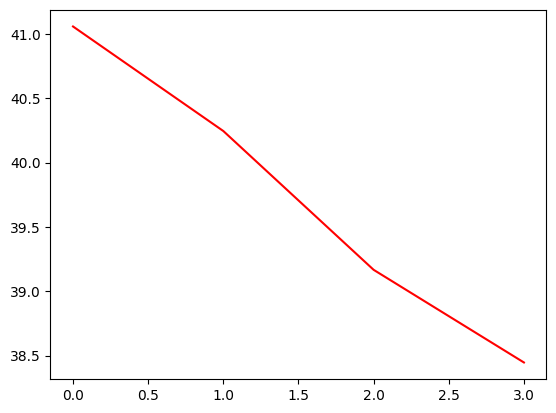

In [278]:
plt.plot(np.abs(np.fft.fft(data[star1].T))[1:5, 0], color='red')
plt.show()

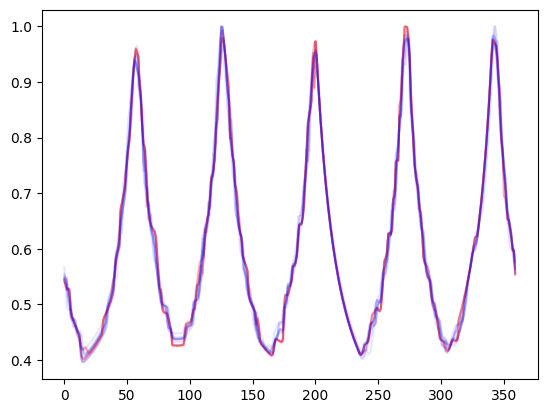

In [279]:
plt.plot(data[star1].T[:,:9], color='red', alpha=0.1) 
plt.plot(data[star2].T[:,:9], color='blue', alpha=0.1) 
plt.show()

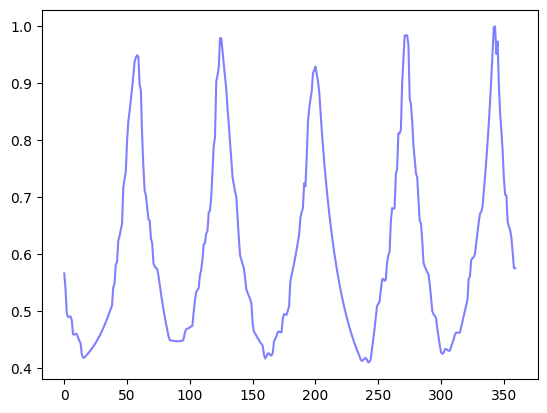

In [280]:
plt.plot(data[star2].T[:,8], color='blue', alpha=0.5) 
plt.show()

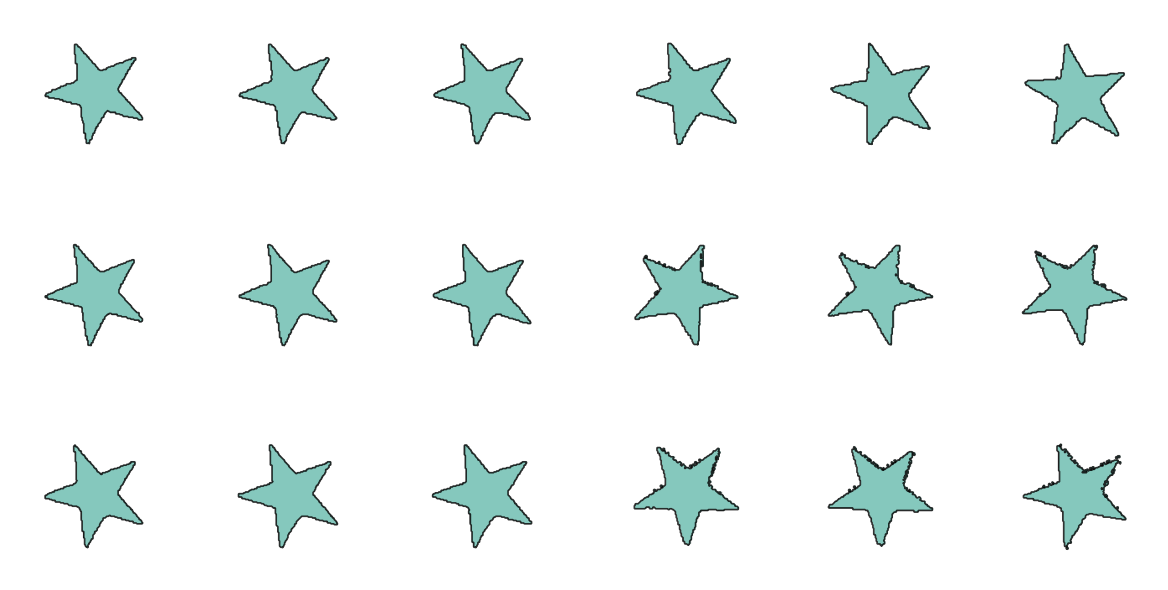


=== Left vs Right (regionprops 내장 속성만) ===
                          left_mean  left_std  right_mean  right_std  \
area_filled                4964.333    78.570    5195.444     56.670   
area                       4964.333    78.570    5192.111     56.929   
equivalent_diameter_area     79.501     0.627      81.306      0.446   
axis_minor_length            88.648     0.957      91.667      1.446   
feret_diameter_max          122.179     1.501     125.424      1.350   
area_convex                9434.889   204.992    9848.778     69.298   
perimeter                   482.522     6.247     534.902     31.737   
perimeter_crofton           460.228     5.935     521.199     37.674   
area_bbox                 13948.000   321.441   14422.667    302.728   
euler_number                  1.000     0.000      -1.889      3.219   
eccentricity                  0.360     0.027       0.268      0.103   
centroid-1                  102.802     0.485     100.496      3.535   
centroid_local-0    

/tmp/ipykernel_3472927/221151457.py:167: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t, p = ttest_ind(R, L, equal_var=False)


In [281]:
import matplotlib.cm as cm

def recolor_star_for_display(img_rgb, *, cmap_name="Set3", color_idx=0, alpha=0.9, edge=False, ax=None):
    """
    표시용으로만 전경(별) 픽셀을 cmap(Set3 등)에서 뽑은 색으로 칠해 반환.
    cmap_name : matplotlib colormap 이름 (기본 Set3)
    color_idx : 0~11 (Set3은 12색)
    alpha     : 원본과 섞는 비율
    edge      : 외곽선 표시 여부
    ax        : 외곽선을 그릴 matplotlib Axes
    """
    # float 변환
    img = img_rgb.astype(np.float32).copy()
    if img.max() > 1.0:
        img /= 255.0

    # 마스크 만들기
    gray = rgb2gray(img)
    thr  = threshold_otsu(gray)
    mask = gray < thr

    # colormap에서 색 뽑기
    cmap = plt.colormaps[cmap_name]
    ncolors = cmap.N
    c = np.array(cmap(color_idx % ncolors)[:3], dtype=np.float32).reshape(1,1,3)

    # 색 입히기
    img[mask] = (1 - alpha) * img[mask] + alpha * c

    # 외곽선
    if edge and ax is not None:
        from skimage import measure
        contours = measure.find_contours(mask.astype(float), 0.5)
        for cnt in contours:
            ax.plot(cnt[:,1], cnt[:,0], lw=1.2, color='k', alpha=0.8)

    return img


# -*- coding: utf-8 -*-
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import pandas as pd

from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops_table
from scipy.stats import ttest_ind


SUBJECT_DIR = "shapes/star"

star_list_left  = star1[0][:9]
star_list_right = star2[0][:9]


def to_rgb(arr):
    arr = np.asarray(arr)
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=-1)
    if arr.ndim == 3 and arr.shape[2] == 4:
        arr = arr[..., :3]
    return arr

def draw_leaf(path):
    img = mpimg.imread(path)
    if img.dtype != np.float32 and img.dtype != np.float64:
        img = img.astype(np.float32) / 255.0
    H, W = img.shape[:2]
    return img, (W/2.0, H/2.0)

def cohens_d(x, y):
    x = np.asarray(x); y = np.asarray(y)
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    sx, sy = np.var(x, ddof=1), np.var(y, ddof=1)
    sp = np.sqrt(((nx-1)*sx + (ny-1)*sy) / (nx+ny-2))
    return (np.mean(y) - np.mean(x)) / sp if sp > 0 else np.nan


def summarize_and_test(df, metric):
    L = df.loc[df.group=='left',  metric].dropna().values
    R = df.loc[df.group=='right', metric].dropna().values
    if len(L) < 2 or len(R) < 2:
        t, p, d = np.nan, np.nan, np.nan
        lm, ls, rm, rs = np.nan, np.nan, np.nan, np.nan
    else:
        t, p = ttest_ind(R, L, equal_var=False)
        d = cohens_d(L, R)
        lm, ls = L.mean(), L.std(ddof=1)
        rm, rs = R.mean(), R.std(ddof=1)
    return pd.Series({
        'left_mean':  lm if 'lm' in locals() else np.nan,
        'left_std':   ls if 'ls' in locals() else np.nan,
        'right_mean': rm if 'rm' in locals() else np.nan,
        'right_std':  rs if 'rs' in locals() else np.nan,
        'diff_right_minus_left': (np.nanmean(R) - np.nanmean(L)),
        'p_value': p,
        'cohens_d': d
    })






def measure_with_regionprops(img_rgb, *, spacing=None):
    gray = rgb2gray(img_rgb)
    thr  = threshold_otsu(gray)
    mask = gray < thr
    lab  = label(mask)
    if lab.max() == 0:
        return None

    props = [
        "label",
        "area",
        "area_bbox",
        "area_convex",
        "area_filled",
        "axis_major_length",
        "axis_minor_length",
        "eccentricity",
        "equivalent_diameter_area",
        "euler_number",
        "extent",
        "feret_diameter_max",
        "orientation",
        "perimeter_crofton",
        "perimeter",
        "solidity",
        "centroid",
        "centroid_local",
    ]

    tbl = regionprops_table(lab, intensity_image=gray, spacing=spacing, properties=props)
    dfp = pd.DataFrame(tbl)
    if len(dfp) == 0:
        return None

    row = dfp.loc[dfp["area"].idxmax()].to_dict()

    return {k: (float(v) if np.isscalar(v) else v) for k, v in row.items()}


records = []

fig = plt.figure(figsize=(12, 6))
gs  = gridspec.GridSpec(1, 2, width_ratios=[1, 1])


gs_left = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[0])
for i, num in enumerate(star_list_left):
    ax  = fig.add_subplot(gs_left[i])
    path = os.path.join(SUBJECT_DIR, f"{num}.png")
    img, (tcx, tcy) = draw_leaf(path)
    img = to_rgb(img)
    disp = recolor_star_for_display(img, cmap_name="Set3", alpha=0.95, edge=True, ax=ax)
    ax.imshow(disp); ax.axis('off')

    m = measure_with_regionprops(img)
    if m:
        m.update(dict(group='left', idx=num))
        records.append(m)


gs_right = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[1])
for i, num in enumerate(star_list_right):
    ax  = fig.add_subplot(gs_right[i])
    path = os.path.join(SUBJECT_DIR, f"{num}.png")
    img, (tcx, tcy) = draw_leaf(path)
    img = to_rgb(img)
    disp = recolor_star_for_display(img, cmap_name="Set3", alpha=0.95, edge=True, ax=ax)
    ax.imshow(disp); ax.axis('off')

    m = measure_with_regionprops(img)
    if m:
        m.update(dict(group='right', idx=num))
        records.append(m)

plt.tight_layout()
plt.show()


df = pd.DataFrame(records)


metrics = [
    'off_x','off_y','r_off','eq_radius','angle_deg',
    'eccentricity','axis_major_length','axis_minor_length',
    'solidity','extent','perimeter','perimeter_crofton',
    'feret_diameter_max','equivalent_diameter_area','euler_number', 
]


metrics = [c for c in df.columns if c not in ('group','idx')]




summary = pd.concat([summarize_and_test(df, m) for m in metrics], axis=1)
summary.columns = metrics
summary = summary.T
print("\n=== Left vs Right (regionprops) ===")
print(summary.sort_values("p_value").round(3))




try:
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


    selected_metrics = summary[summary["p_value"] < 0.05].index.tolist()
    print("\n[Selected metrics for LDA (p<0.05)]:", selected_metrics)

  
    X = df[selected_metrics].select_dtypes(include=[np.number]).fillna(0.0).values
    y = (df['group'] == 'right').astype(int).values

    lda = LinearDiscriminantAnalysis()
    lda.fit(X, y)
    score = lda.score(X, y)
    print(f"[LDA fit] training accuracy = {score*100:.1f}%")

except Exception as e:
    print("\n[Skip LDA demo]", e)

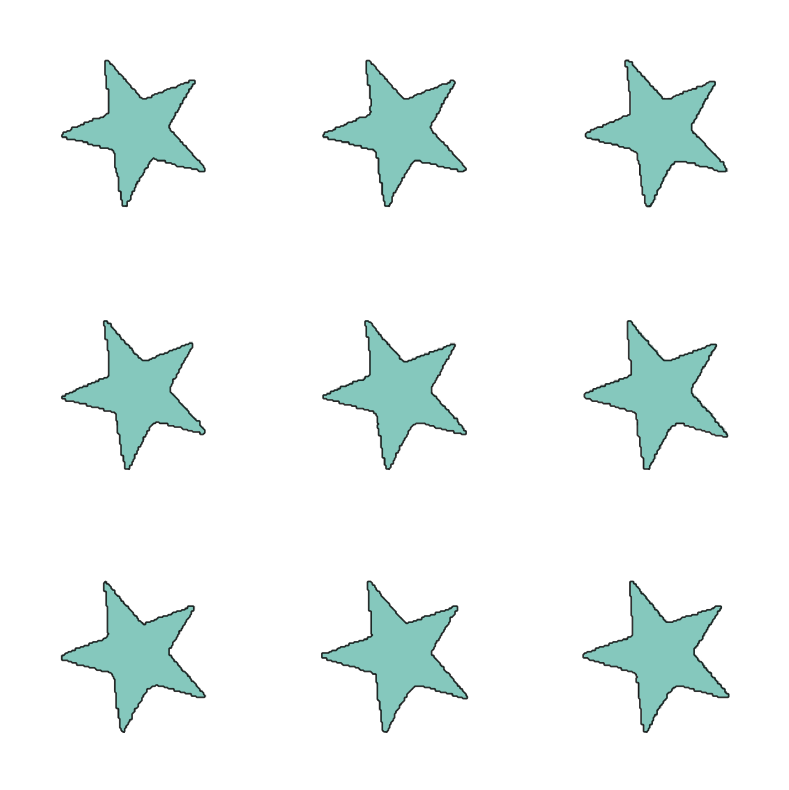

In [282]:
fig = plt.figure(figsize=(8, 8)) 
gs_left = gridspec.GridSpec(3, 3) 

records = []
for i, num in enumerate(star_list_left):
    ax = fig.add_subplot(gs_left[i])
    path = os.path.join(SUBJECT_DIR, f"{num}.png")
    img, (tcx, tcy) = draw_leaf(path)
    img = to_rgb(img)
    disp = recolor_star_for_display(img, cmap_name="Set3", alpha=0.95, edge=True, ax=ax)
    ax.imshow(disp); ax.axis('off')

    m = measure_with_regionprops(img)
    if m:
        m.update(dict(group='left', idx=num))
        records.append(m)

plt.tight_layout()
plt.show()

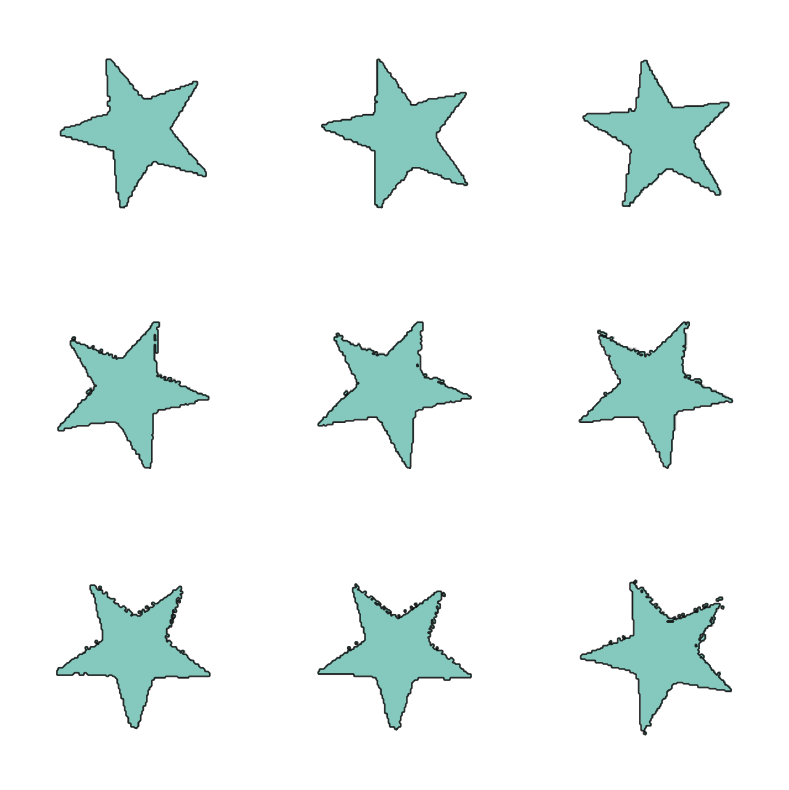

In [283]:
fig = plt.figure(figsize=(8, 8))  
gs_left = gridspec.GridSpec(3, 3)  

records = []
for i, num in enumerate(star_list_right):
    ax = fig.add_subplot(gs_left[i])
    path = os.path.join(SUBJECT_DIR, f"{num}.png")
    img, (tcx, tcy) = draw_leaf(path)
    img = to_rgb(img)
    disp = recolor_star_for_display(img, cmap_name="Set3", alpha=0.95, edge=True, ax=ax)
    ax.imshow(disp); ax.axis('off')

    m = measure_with_regionprops(img)
    if m:
        m.update(dict(group='left', idx=num))
        records.append(m)

plt.tight_layout()
plt.show()